In [1]:
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from cnn_finetune import make_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.metrics import auc

from efficientnet_pytorch import EfficientNet

import shutil


os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# デバイスを設定（CUDAが利用可能ならGPU、そうでなければCPUを使用）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# EfficientNetモデルを事前訓練済みで読み込み、出力クラス数を4に設定
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)

# すべての層を訓練可能に設定（ファインチューニングのため）
for param in model.parameters():
    param.requires_grad = True

# モデルを適切なデバイスに配置
model = model.to(device)

# モデルの構造を出力
print(model)


Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [3]:
transform = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # ランダムに画像の色調を変更
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_2 = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


batch_size = 32

train_dataset.transform=transform
test_dataset.transform=transform_2
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

print(train_dataset.classes)


['1 normal', '2 MALT', '3 GCB', '4 Non-GCB']


In [4]:
from torchsummary import summary

summary(model, (3, 224, 224))

#https://discuss.pytorch.org/t/what-is-1-in-output-shape-of-a-model-in-torch-summary/67790

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [5]:
def train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader):
    # Early stoppingのための初期設定
    the_last_loss = 100  # 最後の損失値を非常に大きな値で初期化
    patience = 10  # 耐性値: この回数だけ損失が減少しなかった場合、早期終了
    trigger_times = 0  # 連続して損失が減少しなかった回数をカウント

    # 各エポックでの訓練開始
    for epoch in range(100):
        model.train()  # モデルを訓練モードに設定
        running_loss = 0.0  # 1エポックの総損失
        correct_num = 0  # 正しく分類されたデータ点の数
        total_num = 0  # 処理されたデータ点の総数
        batch_count = 0  # 処理されたバッチの数

        # 訓練データローダーからバッチを取り出し、学習を行う
        for data, target in cv_train_dataloader:
            inputs, labels = data.to(device), target.to(device)  # データをデバイスに転送

            optimizer.zero_grad()  # 勾配をゼロで初期化

            outputs = model(inputs)  # モデルからの出力を取得
            
            loss = criterion(outputs, labels)  # 損失を計算
            predicted = torch.max(outputs.data, 1)[1]  # 予測値
            correct_num_temp = (predicted == labels).sum()  # 正解数
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]
            loss.backward()  # 勾配の計算
            optimizer.step()  # パラメータの更新
            running_loss += loss.item()
            batch_count += 1 

        # エポックごとの損失と精度を表示
        print(f'Epoch: {epoch + 1}, Loss: {running_loss / batch_count:.3f}, Accuracy: {correct_num * 100 / total_num:.3f}%')
            
        # 検証データセットを用いた損失の計算（早期終了の基準として使用）
        the_current_loss = validation(model, device, cv_valid_dataloader, criterion)
        print('The current loss:', the_current_loss)

        # 早期終了の条件判定
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('Trigger times:', trigger_times)

            if trigger_times >= patience:  # 設定された耐性値を超えた場合、訓練を早期に終了
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('Trigger times: 0')
            trigger_times = 0  # トリガー回数をリセット

        the_last_loss = the_current_loss  # 最後の損失を更新

    return model  # 訓練が終了したモデルを返す


In [6]:
def validation(model, device, cv_valid_dataloader, criterion):
    """
    モデルの検証を行う関数。
    
    Args:
        model: 検証するモデル。
        device: モデルを実行するデバイス（'cuda'または'cpu'）。
        cv_valid_dataloader: 検証データセットのDataLoader。
        criterion: 損失関数。

    Returns:
        float: 検証データセット上の平均損失。
    """
    model.eval()  # モデルを評価モードに設定
    running_loss = 0  # 損失の累計

    with torch.no_grad():  # 勾配計算を行わない
        for data, target in cv_valid_dataloader:
            inputs, labels = data.to(device), target.to(device)  # データをデバイスに転送

            outputs = model(inputs)  # モデルからの出力を取得
            loss = criterion(outputs, labels)  # 損失を計算
            running_loss += loss.item()  # 損失を累計

    # 検証データセット上の平均損失を計算し、返す
    return running_loss / len(cv_valid_dataloader)


In [ ]:
def test(device, model, test_dataloader):
    model.eval()  # モデルを評価モードに設定
    
    # 正確に予測された数と総数の初期化
    correct_num = 0
    total_num = 0
    
    # 予測、ラベル、スコアを格納するリストの初期化
    predicts_list = []
    labels_list = []
    scores_list = [] 

    # 誤って予測された画像の情報を格納するリストの初期化
    wrong_predictions = []  # 誤って予測された画像のファイルパス
    wrong_predicted_labels = []  # 誤った予測ラベル
    true_labels_for_wrong_predictions = []  # 誤って予測された画像の正しいラベル

    with torch.no_grad():  # 勾配計算を無効化
        for i, (data, target) in enumerate(test_dataloader):
            inputs, labels = data.to(device), target.to(device)  # データをデバイスに転送
            outputs = model(inputs)  # モデルで予測
            m = nn.Softmax(dim=1)
            probs = m(outputs)  # 予測結果の確率
            
            _, predicted = torch.max(outputs.data, 1)  # 最も高い確率のラベルを予測として選択
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()  # 正確に予測された数を更新
            total_num += data.shape[0]  # 総数を更新

            # 誤って予測されたインデックスを探索し、情報を保存
            wrong_indices = (predicted != labels).nonzero(as_tuple=True)[0].tolist()
            for idx in wrong_indices:
                wrong_file_path = test_dataloader.dataset.samples[i * test_dataloader.batch_size + idx][0]
                wrong_predictions.append(wrong_file_path)
                wrong_predicted_labels.append(predicted[idx].item())  # 誤った予測ラベル
                true_labels_for_wrong_predictions.append(labels[idx].item())  # 正しいラベル
            
            # データをCPUに転送（後の処理用）
            device2 = torch.device('cpu')
            labels = labels.to(device2)
            predicted = predicted.to(device2)
            probs = probs.to(device2)
            labels_list.append(labels)
            predicts_list.append(predicted)
            scores_list.append(probs)  

    # リストをテンソルに結合
    labels = torch.cat(labels_list)
    predicted = torch.cat(predicts_list)
    scores = torch.cat(scores_list)  

    # ROC曲線の計算に必要な準備
    labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])  # ラベルの二値化

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])  # 各クラスのAUCを計算

    # 混同行列と各種評価指標の計算
    C = confusion_matrix(labels, predicted)
    ac = accuracy_score(labels, predicted)
    pre = precision_score(labels, predicted, average='macro')
    re = recall_score(labels, predicted, average='macro')
    f1 = f1_score(labels, predicted, average='macro')
    AUC = roc_auc_score(labels, scores, multi_class='ovr')  # 全クラスにおけるAUC

    # 評価指標の出力
    print(C)
    print("\n")
    print("test accuracy : %.3f" % ac)
    print("test precison : %.3f" % pre)
    print("test recall : %.3f" % re)
    print("test f1 : %.3f" % f1)
    print("AUC : %.3f" %(AUC))

    # 各クラスごとのAUCを出力
    for i in range(4):
        print("AUC for class {}: {:.3f}".format(i, roc_auc[i]))

    # マクロ平均ROC曲線とAUCの計算
    fpr_macro = dict()
    tpr_macro = dict()
    roc_auc_macro = dict()
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(4):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 4  # 平均を取る
    fpr_macro["macro"] = all_fpr
    tpr_macro["macro"] = mean_tpr
    roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr_macro["macro"], tpr_macro["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_macro["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
    class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB'] 
    for i, color in zip(range(4), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(class_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()


    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(C, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels,annot_kws={'size': 20})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


    # Save wrongly predicted images in a folder structure based on their true and incorrect predicted labels
    base_destination_folder = "/home/yamaguchi/特定4"
    if not os.path.exists(base_destination_folder):
        os.makedirs(base_destination_folder)

    class_folders = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB'] 

    for file_path, true_label, wrong_label in zip(wrong_predictions, true_labels_for_wrong_predictions, wrong_predicted_labels):
        # Folder structure: base_destination_folder/true_label/wrong_predicted_label
        destination_folder = os.path.join(base_destination_folder, class_folders[true_label], class_folders[wrong_label])
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        # Copy the image to this folder
        dest_file_path = os.path.join(destination_folder, os.path.basename(file_path))
        shutil.copy(file_path, dest_file_path)



In [8]:
#k分割交差検証

kf = KFold(n_splits=10)

Loaded pretrained weights for efficientnet-b0
Fold 1------------------------------------------------------------------------------
epoch:1 loss: 0.975 acc: 58.838
The current loss: 0.9703821963408873
trigger times: 0
epoch:2 loss: 0.790 acc: 66.695
The current loss: 0.7315096981002993
trigger times: 0
epoch:3 loss: 0.693 acc: 71.228
The current loss: 0.6002877669691641
trigger times: 0
epoch:4 loss: 0.616 acc: 74.960
The current loss: 0.5219026450746848
trigger times: 0
epoch:5 loss: 0.561 acc: 77.185
The current loss: 0.4721687884912604
trigger times: 0
epoch:6 loss: 0.508 acc: 79.456
The current loss: 0.41102137761966634
trigger times: 0
epoch:7 loss: 0.457 acc: 81.569
The current loss: 0.3894860600765761
trigger times: 0
epoch:8 loss: 0.425 acc: 83.198
The current loss: 0.3741917387662744
trigger times: 0
epoch:9 loss: 0.384 acc: 84.958
The current loss: 0.3012285533013277
trigger times: 0
epoch:10 loss: 0.362 acc: 85.851
The current loss: 0.2907806489047722
trigger times: 0
epoch:1

The current loss: 0.0007586355988946213
trigger times: 0
epoch:93 loss: 0.017 acc: 99.432
The current loss: 0.0007821425197340536
trigger times: 1
epoch:94 loss: 0.018 acc: 99.414
The current loss: 0.0009898726469901203
trigger times: 2
epoch:95 loss: 0.016 acc: 99.544
The current loss: 0.0012549566180568889
trigger times: 3
epoch:96 loss: 0.016 acc: 99.414
The current loss: 0.0010520934750858938
trigger times: 0
epoch:97 loss: 0.014 acc: 99.525
The current loss: 0.0016945417932479796
trigger times: 1
epoch:98 loss: 0.015 acc: 99.535
The current loss: 0.0015794908721296287
trigger times: 0
epoch:99 loss: 0.017 acc: 99.414
The current loss: 0.0012406027451112643
trigger times: 0
epoch:100 loss: 0.014 acc: 99.460
The current loss: 0.0007747912983547551
trigger times: 0
[[138   6   2   4]
 [  0 119   0   3]
 [  1   5  59 145]
 [  0   0  48 447]]


test accuracy : 0.781
test precison : 0.799
test recall : 0.770
test f : 0.772
AUC : 0.875
AUC for class 0: 0.998
AUC for class 1: 0.999
AUC fo

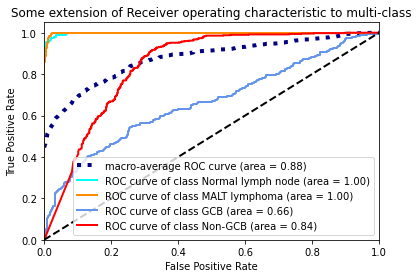

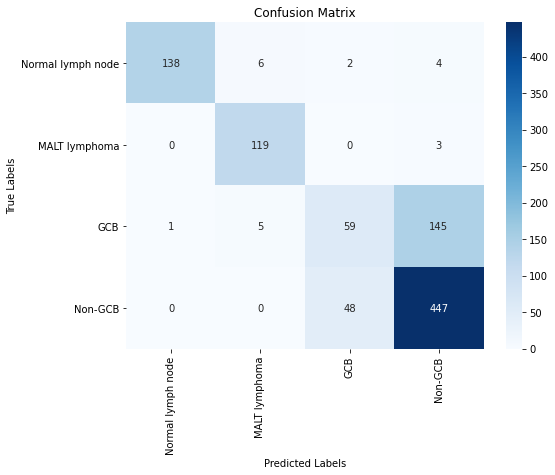

Loaded pretrained weights for efficientnet-b0
Fold 2------------------------------------------------------------------------------
epoch:1 loss: 0.969 acc: 58.913
The current loss: 1.036324567072803
trigger times: 0
epoch:2 loss: 0.778 acc: 67.151
The current loss: 0.7272192154112938
trigger times: 0
epoch:3 loss: 0.693 acc: 71.153
The current loss: 0.6378047468024306
trigger times: 0
epoch:4 loss: 0.633 acc: 73.667
The current loss: 0.5459730026389783
trigger times: 0
epoch:5 loss: 0.580 acc: 76.440
The current loss: 0.48704240870124305
trigger times: 0
epoch:6 loss: 0.525 acc: 78.498
The current loss: 0.6658431200485211
trigger times: 1
epoch:7 loss: 0.473 acc: 81.225
The current loss: 0.7081044478968362
trigger times: 2
epoch:8 loss: 0.426 acc: 83.087
The current loss: 0.37895412851052934
trigger times: 0
epoch:9 loss: 0.389 acc: 84.548
The current loss: 0.3620075750787648
trigger times: 0
epoch:10 loss: 0.376 acc: 84.874
The current loss: 0.2753574276624325
trigger times: 0
epoch:1

KeyboardInterrupt: 

In [9]:
%%time

# メイン関数を定義する
def main():
   
    # 各フォールドをループし、データセットを訓練と検証のサブセットに分割
    for _fold, (train_index, valid_index) in enumerate(kf.split(np.arange(len(train_dataset)))):
        
        # 利用可能であればGPUを使用し、そうでなければCPUを設定
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        # プリトレーニング済みの重みでモデルを初期化し、出力クラスの数を設定
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)
        
        # ファインチューニングのためにすべてのモデルパラメータを訓練可能に設定
        for param in model.parameters():
            param.requires_grad = True
        model = model.to(device)

        # バッチサイズを設定し、損失関数とオプティマイザーを定義
        batch_size = 32
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
        # クロスバリデーションの訓練と検証用のサブセットを作成し、それぞれのデータローダーを定義
        cv_train_dataset = Subset(train_dataset, train_index)
        cv_train_dataloader = DataLoader(cv_train_dataset, batch_size, shuffle=True)
        cv_valid_dataset = Subset(train_dataset, valid_index)
        cv_valid_dataloader = DataLoader(cv_valid_dataset, batch_size, shuffle=False)
        
        # 現在のフォールド情報を出力
        print(f'Fold {_fold+1}------------------------------------------------------------------------------')
        
        # 現在のフォールドの訓練データでモデルを訓練し、検証データで評価
        model = train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader)
        
        # 分離したテストデータセットでモデルをテスト
        test(device, model, test_dataloader)

# スクリプトがメインプログラムとして実行された場合のみ実行するようにする
if __name__ == '__main__':
    main()
